In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import json
import numpy as np
from tqdm.notebook import tqdm
import os
from datetime import datetime
import matplotlib.pyplot as plt

import re
import pandas as pd
import pickle

# Dataset class
class FastTextDataset(Dataset):
    def __init__(self, texts, labels, vectorizer=None, is_training=True):
        self.texts = texts
        self.labels = labels
        self.is_training = is_training
        
        if vectorizer is None and is_training:
            self.vectorizer = TfidfVectorizer(
                max_features=5000,
                ngram_range=(1, 2),
                min_df=2
            )
            self.features = self.vectorizer.fit_transform(texts)
        else:
            self.vectorizer = vectorizer
            self.features = self.vectorizer.transform(texts)
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        feature = torch.FloatTensor(self.features[idx].toarray()).squeeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.float)  # Use float for BCE
        return feature, label


# Model class
class FastSentimentClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=256):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)
        )
    
    def forward(self, x):
        return self.model(x)

# Logger class with inline plotting
class TrainingLogger:
    def __init__(self, log_dir):
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)
        self.training_log = {
            'step': [],
            'epoch': [],
            'train_loss': [],
            'val_accuracy': [],
            'val_precision': [],
            'val_recall': [],
            'val_f1': []
        }
        
    def log_step(self, step, epoch, loss):
        self.training_log['step'].append(step)
        self.training_log['epoch'].append(epoch)
        self.training_log['train_loss'].append(loss)
        # Fill validation metrics with None for steps without validation
        for metric in ['val_accuracy', 'val_precision', 'val_recall', 'val_f1']:
            self.training_log[metric].append(None)
            
    def log_validation(self, step, metrics):
        # Find the last step entry and update its validation metrics
        if step in self.training_log['step']:
            idx = self.training_log['step'].index(step)
            self.training_log['val_accuracy'][idx] = metrics['accuracy']
            self.training_log['val_precision'][idx] = metrics['precision']
            self.training_log['val_recall'][idx] = metrics['recall']
            self.training_log['val_f1'][idx] = metrics['f1']
            
    def save_logs(self):
        df = pd.DataFrame(self.training_log)
        df.to_csv(os.path.join(self.log_dir, 'training_log.csv'), index=False)
        
    def plot_progress(self, save_file=True, display_inline=True):
        df = pd.DataFrame(self.training_log)
        
        # Create figure and subplots with shared x-axis
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # Calculate optimal number of grid lines
        max_step = df['step'].max()
        grid_step = max(50, int(np.ceil((max_step // 10) / 50.0) * 50))
        
        # Plot training loss
        ax1.plot(df['step'], df['train_loss'], 'b-', label='Training Loss')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss Progress')
        ax1.grid(True)
        ax1.legend()
        ax1.set_xticks(np.arange(0, max_step + grid_step, grid_step))
        
        # Plot validation metrics
        metrics = ['val_accuracy', 'val_precision', 'val_recall', 'val_f1']
        for metric in metrics:
            valid_steps = df[df[metric].notna()]['step']
            valid_values = df[df[metric].notna()][metric]
            ax2.plot(valid_steps, valid_values, 'o-', label=metric.replace('val_', '').capitalize())
        
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Score')
        ax2.set_title('Validation Metrics Progress')
        ax2.grid(True)
        ax2.legend()
        ax2.set_xticks(np.arange(0, max_step + grid_step, grid_step))
        
        ax1.yaxis.set_major_locator(plt.MaxNLocator(10))
        ax2.yaxis.set_major_locator(plt.MaxNLocator(10))
        
        ax1.grid(True, which='minor', linestyle=':', alpha=0.2)
        ax2.grid(True, which='minor', linestyle=':', alpha=0.2)
        
        plt.tight_layout()
        
        if save_file:
            plt.savefig(os.path.join(self.log_dir, 'training_progress.png'), dpi=300, bbox_inches='tight')
        
        if display_inline:
            plt.show()
        else:
            plt.close()

# Training and evaluation functions
# Model class
class FastSentimentClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=256):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)  # Single output logit
        )
    
    def forward(self, x):
        return self.model(x)

# Training function
def train_model(model, train_loader, val_loader, device, logger, epochs=5):
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with logits
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)
    
    best_val_acc = 0
    global_step = 0
    
    for epoch in range(epochs):
        model.train()
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}')
        for features, labels in progress_bar:
            features, labels = features.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(features).squeeze(1)  # Flatten logits for BCE loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            logger.log_step(global_step, epoch + 1, loss.item())
            progress_bar.set_postfix({'loss': loss.item()})
            
            if global_step % 50 == 0:
                val_metrics = evaluate_model(model, val_loader, device)
                logger.log_validation(global_step, val_metrics)
                scheduler.step(val_metrics['accuracy'])
                
                # Save the best model
                if val_metrics['accuracy'] > best_val_acc:
                    best_val_acc = val_metrics['accuracy']
                    model_path = os.path.join('trained_model', 'best_model.pt')
                    torch.save(model.state_dict(), model_path)
            
            global_step += 1
        
        # Validation at the end of each epoch
        val_metrics = evaluate_model(model, val_loader, device)
        logger.log_validation(global_step, val_metrics)
        print(f"\nEpoch {epoch + 1} Validation metrics:")
        for metric, value in val_metrics.items():
            print(f"{metric}: {value:.4f}")

    # Plot progress after training is complete
    logger.plot_progress(save_file=True, display_inline=True)

# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    
    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features).squeeze(1)  # Flatten logits
            predicted = torch.sigmoid(outputs) >= 0.5  # Apply sigmoid and threshold
            
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
    
    predictions = np.array(predictions, dtype=int)
    actual_labels = np.array(actual_labels, dtype=int)
    
    accuracy = (predictions == actual_labels).mean()
    precision = (predictions[predictions == 1] == actual_labels[predictions == 1]).mean() if sum(predictions == 1) > 0 else 0
    recall = (predictions[actual_labels == 1] == actual_labels[actual_labels == 1]).mean() if sum(actual_labels == 1) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


# Data preparation function
def prepare_data(file_path):
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]

    texts = []
    labels = []

    for item in data:
        text = item['text']
        match = re.search(r"### Assistant: (\w+)", text)
        if match:
            texts.append(text)
            labels.append(1 if match.group(1) == "positive" else 0)
        else:
            # Extract the actual text and label from the additional context information
            instruction_pattern = r"Instruction:\s*What is the sentiment of this tweet\?\s*Please choose an answer from \{(\w+)/(\w+)/(\w+)\}"
            match = re.search(instruction_pattern, text)
            if match:
                label_map = {'negative': 0, 'neutral': 1, 'positive': 1}
                actual_text = text.split("###")[1].strip()
                actual_label = label_map[match.group(label_map[match.group(1)])]
                texts.append(actual_text)
                labels.append(actual_label)

    return texts, labels

Using device: mps

Data distribution:
Total samples: 4846
Positive samples: 1363
Negative samples: 3483

Starting training...


Epoch 1/5:   0%|          | 0/109 [00:00<?, ?it/s]


Epoch 1 Validation metrics:
accuracy: 0.7861
precision: 1.0000
recall: 0.2523
f1: 0.4029


Epoch 2/5:   0%|          | 0/109 [00:00<?, ?it/s]


Epoch 2 Validation metrics:
accuracy: 0.9278
precision: 0.9882
recall: 0.7568
f1: 0.8571


Epoch 3/5:   0%|          | 0/109 [00:00<?, ?it/s]


Epoch 3 Validation metrics:
accuracy: 0.9613
precision: 0.9898
recall: 0.8739
f1: 0.9282


Epoch 4/5:   0%|          | 0/109 [00:00<?, ?it/s]


Epoch 4 Validation metrics:
accuracy: 0.9536
precision: 0.9895
recall: 0.8468
f1: 0.9126


Epoch 5/5:   0%|          | 0/109 [00:00<?, ?it/s]


Epoch 5 Validation metrics:
accuracy: 0.9562
precision: 0.9896
recall: 0.8559
f1: 0.9179


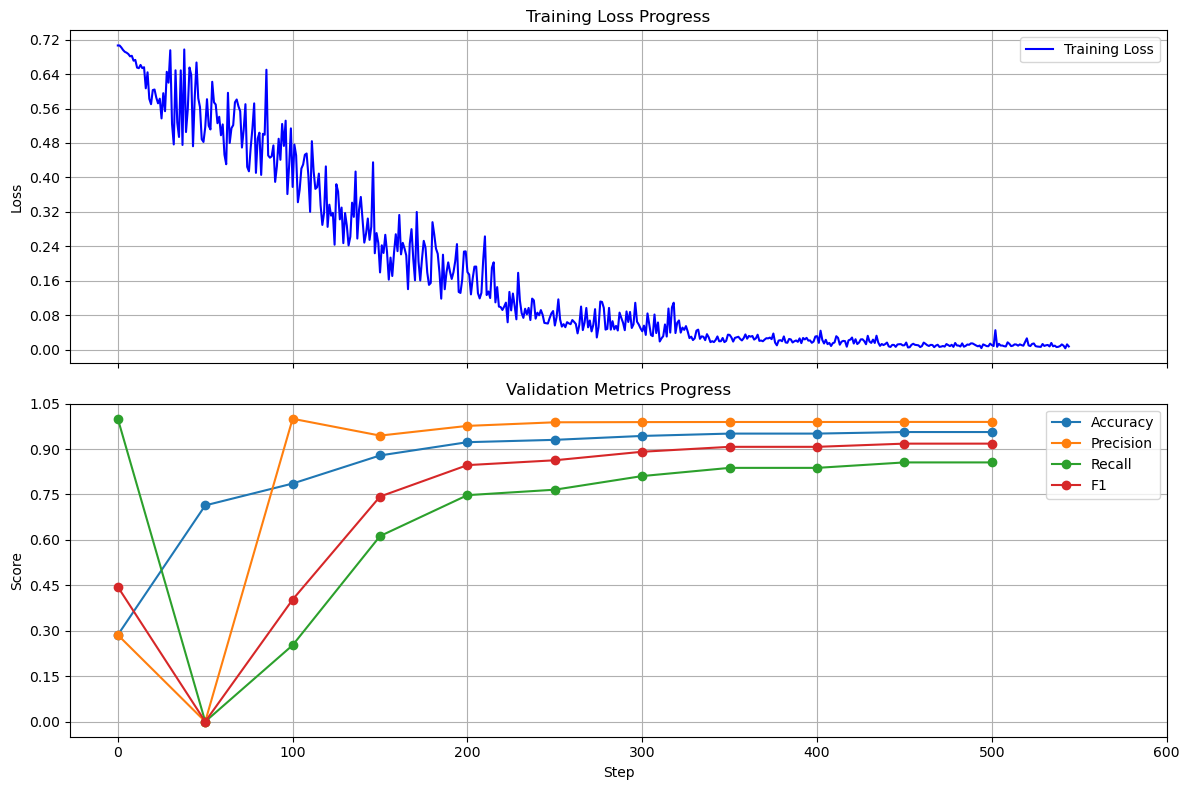


Evaluating on test set...

Test metrics:
accuracy: 0.9515
precision: 0.9802
recall: 0.8547
f1: 0.9131


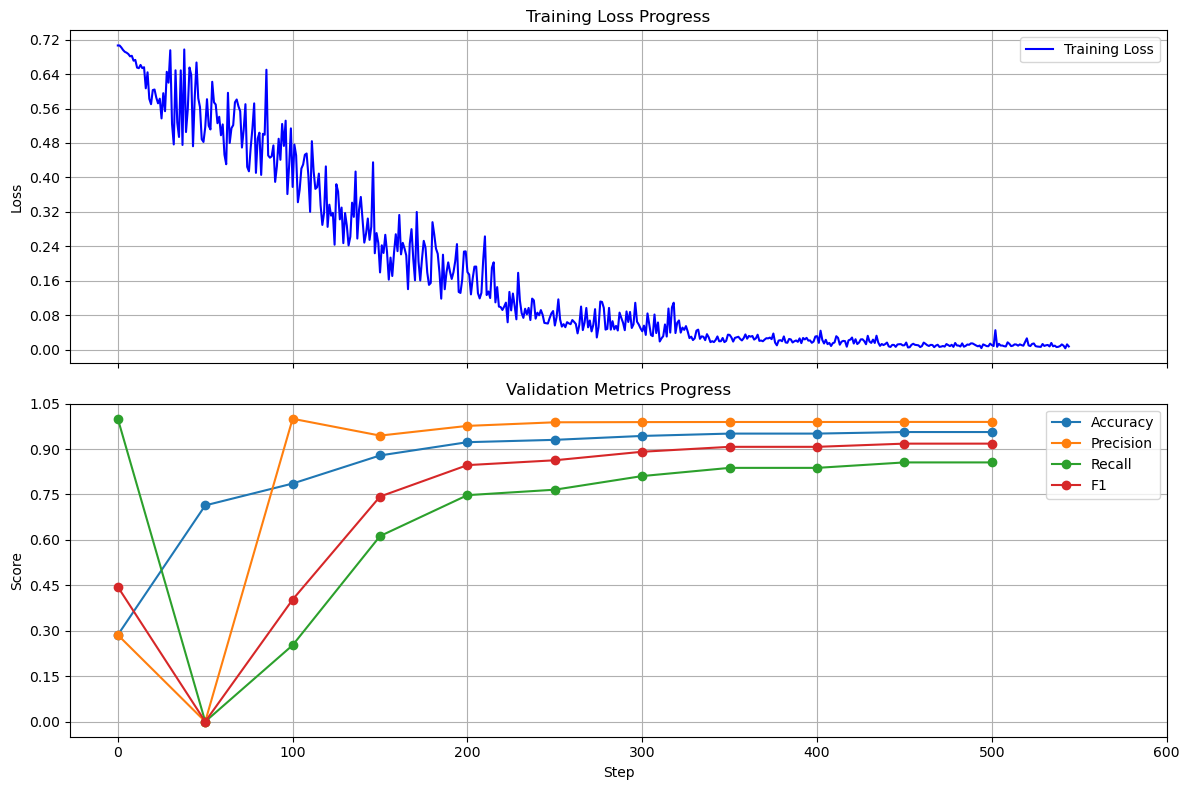


Training completed!
Model and vectorizer saved in 'trained_model/' directory
Logs and plots saved in 'logs/' directory


In [11]:



# Main execution
# Create necessary directories
os.makedirs('trained_model', exist_ok=True)
os.makedirs('logs', exist_ok=True)

# Initialize logger
logger = TrainingLogger('logs')

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load and prepare data
texts, labels = prepare_data("data/instruct_finance_data.json")

# Display data distribution
print("\nData distribution:")
print(f"Total samples: {len(labels)}")
print(f"Positive samples: {sum(labels)}")
print(f"Negative samples: {len(labels) - sum(labels)}")

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1, random_state=42
)

# Create datasets
train_dataset = FastTextDataset(train_texts, train_labels)
vectorizer = train_dataset.vectorizer
val_dataset = FastTextDataset(val_texts, val_labels, vectorizer, is_training=False)
test_dataset = FastTextDataset(test_texts, test_labels, vectorizer, is_training=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model
input_size = len(vectorizer.get_feature_names_out())
model = FastSentimentClassifier(input_size).to(device)

# Train model
print("\nStarting training...")
train_model(model, train_loader, val_loader, device, logger)

# Save vectorizer
with open(os.path.join('trained_model', 'vectorizer.pkl'), 'wb') as f:
    pickle.dump(vectorizer, f)

# Final evaluation
print("\nEvaluating on test set...")
test_metrics = evaluate_model(model, test_loader, device)
print("\nTest metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Save test metrics
with open(os.path.join('logs', 'test_metrics.json'), 'w') as f:
    json.dump(test_metrics, f, indent=2)

# Save and plot training logs
logger.save_logs()
logger.plot_progress()

print("\nTraining completed!")
print("Model and vectorizer saved in 'trained_model/' directory")
print("Logs and plots saved in 'logs/' directory")